# CO2 Emissions Tracker

This will will contain:
- Data extraction 
- Data visualation 
- Dataset creation 
- Model preperation
- Training algorithm 
- Model testing
- Model preview

# Note

In order to run the code, ensure a python environment is created and install the required packaged. 

## EDA 

### Data Perperation

### Importing plugins

In [1]:
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import lightning as l 
import matplotlib.pyplot as plt 
import plotly.express as px
pd.options.plotting.backend = "plotly"
pd.options.display.max_columns = 200
import seaborn as sns





### Step 1. Data Cleanup, and standardizing the format

In [2]:
# loading in the data

#importing CO2 emissions data
co2_emission_data = pd.read_csv(filepath_or_buffer='./data/Annual CO2 Emissions.csv')
gdp_data = pd.read_csv('./data/gdp/gdp_data.csv')
land_size =  pd.read_csv('./data/world_country_stats.csv')
surface_temp = pd.read_csv('./data/temperature/monthly-average-surface-temperatures-by-year.csv')
population = pd.read_csv('./data/population.csv')
research_spending = pd.read_csv('./data/research-spending-gdp.csv')
energy_use_per_capita = pd.read_csv('./data/per-capita-energy-use.csv')
land_use = pd.read_csv('./data/land_use.csv')
trade = pd.read_csv('./data/Trade.csv')
urban_population = pd.read_csv('./data/urban_population.csv')


In [3]:
# gdp_data[['country_name',  'country_code' , 'year', 'value']]
land_size = land_size[['country', 
                       #'region', 
                       'land_area', 
                       #'fertility_rate', 'median_age'
                       ]].copy()

co2_emission_data = co2_emission_data[['Entity', 'Code', 'Year', 'Annual CO2 Emissions (tonnes)']].copy()

In [4]:
## this section of code is to determine the year range for the different datasets
## the suitable range has been chosen such that we are getting the maximum of the oldest year, and minimum of the most current year, 
## this ensures we avoid having too many missing values

temp_years = [int(col) for col in surface_temp.columns if col.isdigit()]

year_ranges = {
    'CO2': (co2_emission_data['Year'].min(), co2_emission_data['Year'].max()),
    'GDP': (gdp_data['year'].min(), gdp_data['year'].max()),
    'Temperature': (min(temp_years), max(temp_years)),
    'Population': (population['Year'].min(), population['Year'].max()),
    # 'Research Spending' : (research_spending['Year'].min(), research_spending['Year'].max()),
    'energy_use_per_capita' : (energy_use_per_capita['Year'].min(), energy_use_per_capita['Year'].max()),
    'land_use' : (land_use['Year'].min(), land_use['Year'].max()),
    'trade' : (trade['Year'].min(), trade['Year'].max()),
    'urban_population' : (urban_population['Year'].min(), urban_population['Year'].max()),
    # 'per_capita_energy_source' : (per_capita_energy_source['Year'].min(), per_capita_energy_source['Year'].max()),
    }

# Print current ranges
for dataset, (start, end) in year_ranges.items():
    print(f"{dataset}: {start} - {end}")

# Calculate optimal range
optimal_start = max(range[0] for range in year_ranges.values())
optimal_end = min(range[1] for range in year_ranges.values())

print(f"\nOptimal year range: {optimal_start} - {optimal_end}")

CO2: 1750 - 2022
GDP: 1960 - 2022
Temperature: 1950 - 2024
Population: -10000 - 2023
energy_use_per_capita: 1965 - 2023
land_use: -10000 - 2023
trade: 1960 - 2022
urban_population: 1960 - 2022

Optimal year range: 1965 - 2022


In [5]:
# creating a function to standardize the datasets, so code is not repeated below. 
def std_dataset(df,id_columns,value_column, year_column='year'):
    # input of id_column should be: country, iso3
    if df[year_column].dtype != 'int64':
        df[year_column] = pd.to_numeric(df[year_column],errors='coerce')
    
    #filtering for optimal range
    df_filtered = df[
                    (df[year_column] >= optimal_start) &
                    (df[year_column] <= optimal_end)]
    
    # sorting by country code and year
    df_filtered = df_filtered.sort_values([id_columns[1],year_column])

    return df_filtered


In [6]:
# reshaping the surface temperature dataset o that it is in long format (countries are the rows, years are the columns) 
surface_temp_long = surface_temp.melt(id_vars=['Entity', 'Code', 'Month'], var_name='Year', value_name='Temperature')

#converting year to integer, and filtering out the optimal range
surface_temp_long['Year'] = pd.to_numeric(surface_temp_long['Year'],errors='coerce')
surface_temp_long = surface_temp_long[
                                        (surface_temp_long['Year'] >= optimal_start) &
                                        (surface_temp_long['Year'] <= optimal_end)]
surface_temp_long = surface_temp_long.sort_values(['Code', 'Year'])
surface_temp_long = surface_temp_long.groupby(['Entity', 'Code', 'Year'])['Temperature'].mean().reset_index().copy()



# Reshaping CO2 emissions to be in long format as well as optimal years
co2_long = std_dataset(co2_emission_data, id_columns=['Entity', 'Code'], value_column='Annual CO2 Emissions (tonnes)', year_column='Year')

# Reshaping GDP to be in long format as well as optimal years:
gdp_long = std_dataset(gdp_data,id_columns=['country_name', 'country_code'],value_column='value', year_column='year')


population_long  = std_dataset(population, id_columns=['Entity', 'Code'], value_column= 'Population (historical)', year_column='Year')

research_spending_long  = std_dataset(research_spending, id_columns=['Entity', 'Code'], value_column= 'R&D Spending', year_column='Year')

energy_use_per_capita_long = std_dataset(energy_use_per_capita, id_columns=['Entity', 'Code'], value_column= 'Primary energy consumption per capita (kWh/person)', year_column='Year')

land_use_long = std_dataset(land_use, id_columns=['Country', 'ISO'], value_column= ['Land use: Built-up area', 'Land use: Grazingland', 'Land use: Cropland'], year_column='Year')

trade_long = std_dataset(trade, id_columns=['Country', 'ISO'], value_column= ['Trade in services (% of GDP)'], year_column='Year')

urban_population_long = std_dataset(urban_population, id_columns=['Country', 'ISO'], value_column= ['Urban population (% of total population)'], year_column='Year')




# Renaming the columns so its standardized: 
surface_temp_long.rename(columns={'Code' : 'ISO', 'Year' : 'Year', 'Entity' : 'Country'},inplace=True)
co2_long.rename(columns={'Entity' : 'Country', 'Code' : 'ISO'}, inplace= True)
gdp_long.rename(columns={'country_name' : 'Country', 'country_code' : 'ISO', 'year' : 'Year', 'value' : 'GDP'}, inplace= True)
population_long.rename(columns={'Entity' : 'Country', 'Code' : 'ISO', 'Population (historical)' : 'Population' }, inplace= True)
research_spending_long.rename(columns={'Code' : 'ISO', 'Year' : 'Year', 'Entity' : 'Country', 'Research and development expenditure (% of GDP)' : 'R&D Spending'},inplace=True)
energy_use_per_capita_long.rename(columns={'Code' : 'ISO', 'Year' : 'Year', 'Entity' : 'Country'},inplace=True)




In [7]:

# creating country codes index
country_codes = co2_long.set_index(['ISO'])
country_codes = country_codes.drop(axis='columns', labels=['Year','Annual CO2 Emissions (tonnes)'])
country_codes.drop_duplicates(keep='first', inplace=True, ignore_index=False)

country_mapping = country_codes['Country'].to_dict()



In [8]:
fig = px.line(co2_long, 
              x='Year',              # specify x-axis column
              y='Annual CO2 Emissions (tonnes)',  # specify y-axis column
              color='ISO',          # use this to create different lines per country
              title='CO2 Emissions by Country (log y scale)',
              width=1500,
              height=1000,
              log_y=True)
# Create custom hover template
fig.update_traces(
    hovertemplate="Country: %{customdata}<br>" +
                  "Year: %{x}<br>" +
                  "CO2 Emissions: %{y:,.2f} tonnes<br>" +
                  "<extra></extra>"
)

# Update the trace names using your mapping
for trace in fig.data:
    # Get current name (country code) and find corresponding country name
    country_code = trace.name
    country_name = country_mapping.get(country_code, country_code)  # fallback to code if not found
    trace.name = country_name
    trace.customdata = [[country_name, country_code] for _ in range(len(trace.x))]


# Update layout with better labels
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="CO2 Emissions (t)",
    title_x=0.5,  # Center the title
)

# Show the plot
fig.show()

In [9]:
# in this section of the code, I am combining all the datasets based on the country ISO codes, as they are there for majority of the data, and should be standardized.  
# The 
def merge_df(base_df,new_df,values):
    # get unique ISOs from base df
    base_df_ISO_count = base_df.ISO.unique().size
    new_df_ISO_count = new_df.ISO.unique().size

    # creating sets for easier comparison 
    base_iso_set = set(base_df.ISO.unique())
    new_iso_set = set(new_df.ISO.unique())

    matching_ISOs = base_iso_set.intersection(new_iso_set)
    missing_ISOs = base_iso_set.difference(new_iso_set)
    
    initial_stats = {
        'base_df_countries' : base_df_ISO_count,
        'new_df_countries' : new_df_ISO_count,
        'matching_countries': len(matching_ISOs),
        'missing_countries' : len(missing_ISOs)
    }

    # merging the columns
    merged_df = base_df.merge(
                                new_df[['ISO', 'Year'] + values],
                                on=['ISO', 'Year'],
                                how='left'
    )


     # Track final stats
    final_iso_count = merged_df.ISO.unique().size
    
    merge_stats = {
        **initial_stats,
        'final_countries': final_iso_count,
        'missing_iso_list': list(missing_ISOs)
    }
    
    return merged_df, merge_stats




    

In [10]:
#converting the per capita or percentage value to whole figures for consistent comparison. 
energy_use_per_capita_long['Primary energy consumption (kWh)'] = energy_use_per_capita_long['Primary energy consumption per capita (kWh/person)'] * population_long['Population']

trade_long['Trade in services ($)'] = (trade_long['Trade in services (% of GDP)']/100) * gdp_long['GDP']

urban_population_long['Urban population (people)'] = (urban_population_long['Urban population (% of total population)']/100) * population_long['Population']



In [11]:
dataset, stats = merge_df(base_df=co2_long, new_df=gdp_long, values=['GDP'])
print(stats)
dataset,stats = merge_df(base_df=dataset, new_df=surface_temp_long, values=['Temperature'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=population_long, values=['Population'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=research_spending_long, values=['R&D Spending'])
print(stats)

print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=energy_use_per_capita_long, values=['Primary energy consumption per capita (kWh/person)'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=land_use_long, values=['Land use: Built-up area', 'Land use: Grazingland', 'Land use: Cropland'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=trade_long, values=['Trade in services ($)'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=urban_population_long, values=['Urban population (people)'])
print(stats)




# creating a filtered dataset which doesnt include world 
filtered_dataset = dataset[dataset['ISO'] != 'WLD']



{'base_df_countries': 217, 'new_df_countries': 262, 'matching_countries': 203, 'missing_countries': 14, 'final_countries': 217, 'missing_iso_list': ['MSR', 'COK', 'KOS', 'ATA', 'CXR', 'VGB', 'AIA', 'SHN', 'PRK', 'NIU', 'SPM', 'BES', 'WLF', 'TWN']}
{'base_df_countries': 217, 'new_df_countries': 195, 'matching_countries': 185, 'missing_countries': 32, 'final_countries': 217, 'missing_iso_list': ['MSR', 'DMA', 'LCA', 'SXM', 'KOS', 'MHL', 'PLW', 'TWN', 'KNA', 'MDV', 'VGB', 'ABW', 'NRU', 'SPM', 'GRD', 'WLF', 'BRB', 'FSM', 'CUW', 'TCA', 'NIU', 'BES', 'MLT', 'MAC', 'WLD', 'ATA', 'CXR', 'SGP', 'BMU', 'TUV', 'TON', 'LIE']}
{'base_df_countries': 217, 'new_df_countries': 251, 'matching_countries': 213, 'missing_countries': 4, 'final_countries': 217, 'missing_iso_list': ['CXR', 'ATA', 'WLD', 'KOS']}
{'base_df_countries': 217, 'new_df_countries': 151, 'matching_countries': 144, 'missing_countries': 73, 'final_countries': 217, 'missing_iso_list': ['MSR', 'LBN', 'BEN', 'DMA', 'NCL', 'BTN', 'SLE', 'GU

In [12]:
# the code for generating unique colours was retrieved from Claude Sonnet 3.5 to ensure we have somewhat unique colours for the different countries. 
def generate_unique_colors(n):
    colors = []
    
    # Use different color spaces to ensure variety
    # RGB space variations
    for i in range(n):
        # Use prime numbers to space out the colors
        r = (173 + i * 71) % 256  # Prime number 71
        g = (223 + i * 67) % 256  # Prime number 67
        b = (157 + i * 73) % 256  # Prime number 73
        
        # Adjust vibrancy by mixing less with white
        # Change these ratios to adjust vibrancy (higher ratio = more vibrant)
        # Original was 0.5 (dividing by 2), let's try 0.7
        white_mix = 0.3  # Reduce white mixing for more vibrant colors
        r = int(r * (1 - white_mix) + 255 * white_mix)
        g = int(g * (1 - white_mix) + 255 * white_mix)
        b = int(b * (1 - white_mix) + 255 * white_mix)
        
        colors.append(f'rgb({r}, {g}, {b})')
    
    return colors

# First verify the number of colors generated
colors = generate_unique_colors(217)
print("Number of unique colors:", len(set(colors)))  # Should be 217

# Create the plot
fig = px.scatter_3d(dataset, 
                    x='Annual CO2 Emissions (tonnes)', 
                    log_x= True,
                    y='GDP',
                    log_y=True, 
                    z='Year',
                    color='Country',
                    width=1500,
                    height=1000,
                    color_discrete_sequence=colors,
                    title="Comparison of CO2 Emissions, Country's GDP and Time"
                   )
# # Define which countries you want visible initially
# initial_countries = ['China', 'United States', 'Australia', 'India', 'Russia', 'Japan', 'South Korea']  # Example countries

# # Update traces to set initial visibility
# fig.update_traces(visible='legendonly')  # First set all to hidden
# for trace in fig.data:
#     if trace.name in initial_countries:
#         trace.visible = True  # Make selected countries visible

fig.show()

Number of unique colors: 217


<Axes: >

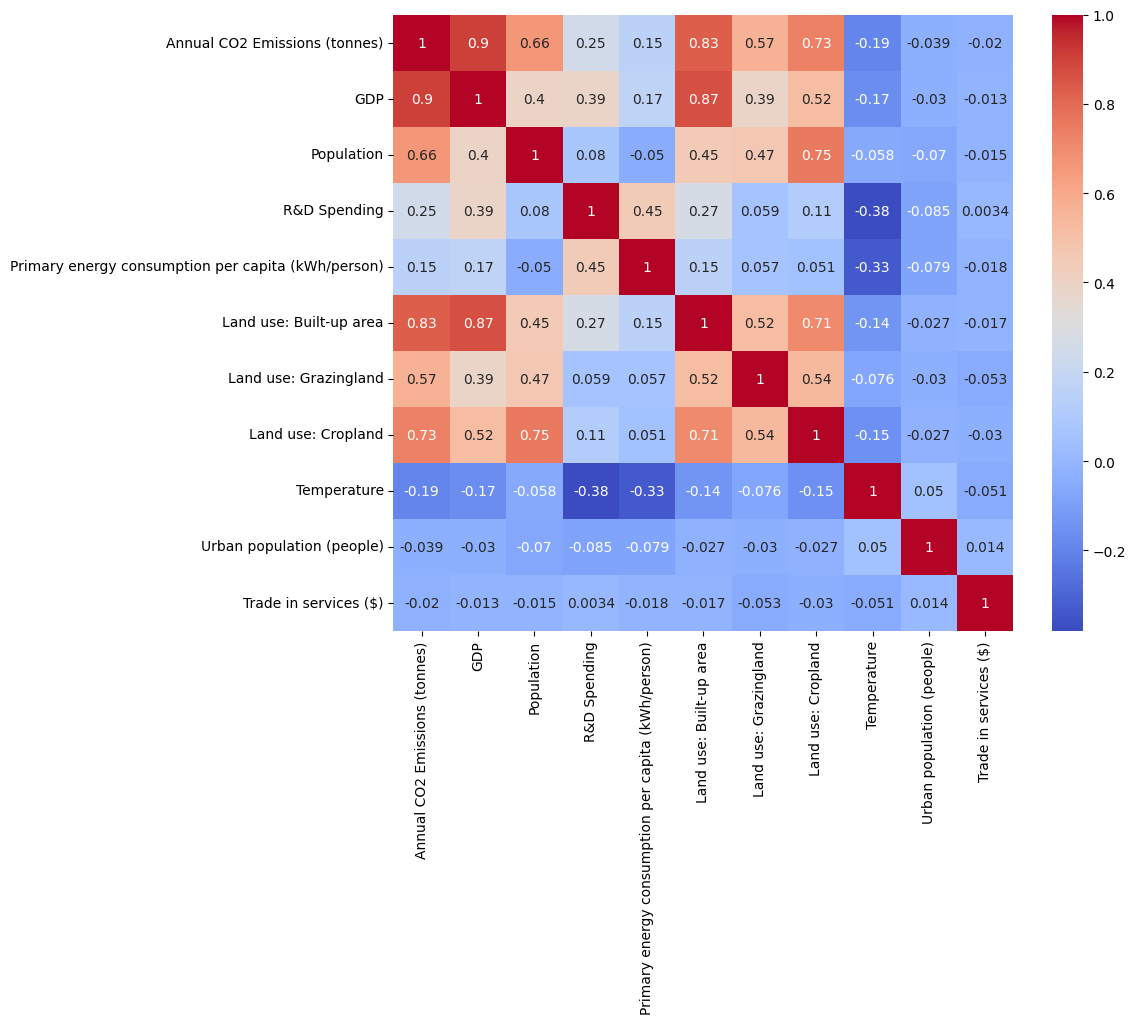

In [13]:
# Correlation heatmap
import seaborn as sns

correlation_matrix = dataset[['Annual CO2 Emissions (tonnes)', 'GDP', 'Population', 'R&D Spending' , 'Primary energy consumption per capita (kWh/person)' ,
                              'Land use: Built-up area', 'Land use: Grazingland', 'Land use: Cropland' ,  'Temperature', 'Urban population (people)' , 'Trade in services ($)']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [14]:
dataset.columns

Index(['Country', 'ISO', 'Year', 'Annual CO2 Emissions (tonnes)', 'GDP',
       'Temperature', 'Population', 'R&D Spending',
       'Primary energy consumption per capita (kWh/person)',
       'Land use: Built-up area', 'Land use: Grazingland',
       'Land use: Cropland', 'Trade in services ($)',
       'Urban population (people)'],
      dtype='object')

In [15]:
# Line plot showing multiple variables over time
# Normalize the variables to compare trends
fig = px.line(dataset, 
              x='Year',              # specify x-axis column
              y='GDP',  # specify y-axis column
              color='Country',          # use this to create different lines per country
              title='CO2 Emissions by Country (log y scale)',
              width=1500,
              height=1000,
              log_y=False)
fig.show()

In [16]:
# Scatter matrix for economic variables
fig = px.scatter_matrix(dataset,
                       dimensions=['Inflation, consumer prices (annual %)',
                                    'Real interest rate (%)',
                                    'Unemployment, total (% of total labor force) (national estimate)'],
                                    width=1500,
                                    height=1000,)
                    
fig.show()

ValueError: Value of 'dimensions_0' is not the name of a column in 'data_frame'. Expected one of ['Country', 'ISO', 'Year', 'Annual CO2 Emissions (tonnes)', 'GDP', 'Temperature', 'Population', 'R&D Spending', 'Primary energy consumption per capita (kWh/person)', 'Land use: Built-up area', 'Land use: Grazingland', 'Land use: Cropland', 'Trade in services ($)', 'Urban population (people)'] but received: Inflation, consumer prices (annual %)

In [ ]:
# Scatter plot with trend line
fig = px.scatter(dataset, 
                    x='GDP', 
                    y='Annual CO2 Emissions (tonnes)',
                    color='Country',
                    trendline="ols",
                    width=1500,
                    height=1000,
                    title='GDP vs CO2 Emissions')
fig.show()